# Business Problem

A empresa Top Bank atua na Europa tendo como principal produto uma conta bancária. Este produto pode manter o salário do cliente e efetuar pagamentos. Essa conta não tem nenhum custo nos primeiros 12 meses, porém, após esse período, o cliente precisa recontratar o banco para os próximos 12 meses e refazer esse processo todos os anos. Recentemente, a equipe de análise notou que a taxa de churn está aumentando.

## Challenge:
Como Cientista de Dados, você precisa criar um plano de ação para diminuir o número de clientes churn e mostrar o retorno financeiro da sua solução.
Além disso, você precisará fornecer um relatório relatando o desempenho de seu modelo e o impacto financeiro de sua solução.
Perguntas que o CEO e a equipe do Analytics gostariam de ver em seu relatório:

1. Qual é a atual taxa de churn do Top Bank?
2. Como a taxa de churn varia mensalmente?
3. Qual é o desempenho do modelo na classificação de clientes como churns?
4. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

## Note:
Como posso responder os 4 desafios do problema???

    R: Conhecer as variáveis (Data Description) e definir plano de desenvolvimento.

# Imports

In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preparation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

# Model and Metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score

# Parameter and Model Saving
import pickle

# Display Jupyter
from IPython.core.display import HTML
from IPython.core.display import Image
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
def numeric_descriptive_statistical(numeric_attributes):
    #Central Tendency - Mean, Median
    mean = pd.DataFrame(numeric_attributes.apply(np.mean)).T
    median = pd.DataFrame(numeric_attributes.apply(np.median)).T

    #Dispersion - Std, Min, Max, range, skew, kurtosis
    standard_deviation = pd.DataFrame(numeric_attributes.apply(np.std)).T
    minimum = pd.DataFrame(numeric_attributes.apply(np.min)).T
    maximum = pd.DataFrame(numeric_attributes.apply(np.max)).T
    distance_between_minimum_and_maximum = pd.DataFrame(numeric_attributes.apply(lambda x: x.max() - x.min())).T
    skewness = pd.DataFrame(numeric_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(numeric_attributes.apply(lambda x: x.kurtosis())).T

    #concatenate
    vizualizer_descriptive_statistical = pd.concat([minimum, maximum, distance_between_minimum_and_maximum, mean, median, standard_deviation, skewness, kurtosis]).T.reset_index()
    vizualizer_descriptive_statistical.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return vizualizer_descriptive_statistical

def n_bins(numeric_column):
    n = numeric_column.shape[0]
    k = round(1 + (3.3 * np.log10(n)))    
        
    return k

def show_univariate_numeric_distribution(numeric_column, bins, title, ylabel, xlabel):
    # Get statistics
    min_val = numeric_column.min()
    max_val = numeric_column.max()
    mean_val = numeric_column.mean()
    med_val = numeric_column.median()
    mod_val = numeric_column.mode()[0]
    
    print('Mínimo:{:.2f}\nMédia:{:.2f}\nMediana:{:.2f}\nModa:{:.2f}\nMáximo:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))


    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (18,6))

    # Plot the histogram   
    ax[0].hist(numeric_column, bins= bins)
    ax[0].set_ylabel(ylabel)

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(numeric_column, vert=False)
    ax[1].set_xlabel(xlabel)

    # Add a title to the Figure
    fig.suptitle(title)
    
    fig.show()
    
    return  None

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = 50
    pd.options.display.max_rows= False
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load Data

In [3]:
data_raw = pd.read_csv('../data/churn.csv')
data_raw

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Data Description

In [4]:
df2 = data_raw.copy()

## Meaning of Data

- **RowNumber**: o número das colunas
- **CustomerID**: identificador único de clientes
- **Surname**: sobrenome do cliente
- **CreditScore**: pontuação de crédito do cliente para o mercado financeiro (quanto maior o score, é um bom pagador)
- **Geography**: o país do cliente
- **Gender**: o gênero do cliente
- **Age**: a idade do cliente
- **Tenure**: número de anos que o cliente está no banco
- **Balance**: o valor que o cliente tem em sua conta
- **NumOfProducts**: o número de produtos que o cliente comprou (no caso, contas)
- **HasCrCard**: se o cliente tiver cartão de crédito
- **IsActiveMember**: se o cliente estiver ativo (nos últimos 12 meses)
- **EstimateSalary**: estimativa de salário anual dos clientes
- **Exited**: se o cliente for churn (*variável resposta*)

## Rename Columns

In [5]:
renamed_columns = ['numero_linha', 'id_cliente', 'sobrenome', 'score_credito', 'geografia', 'genero', 'idade', 'tempo_permanencia', 
                   'saldo', 'numero_de_contas', 'tem_cartao_credito', 'membro_ativo', 'salario_estimado', 'Churn']
df2.columns = renamed_columns

df2.head(1)

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1


## Data Dimensions

In [6]:
data_dimensions = df2.shape
print(f'A base de dados possui {data_dimensions[0]} clientes e {data_dimensions[1]} variáveis.')

A base de dados possui 10000 clientes e 14 variáveis.


## Data Types

In [7]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito      int64
membro_ativo            int64
salario_estimado      float64
Churn                   int64
dtype: object

### Change Data Types

In [8]:
# Alterando o tipo de dados das colunas binárias: 'tem_cartao_credito', 'membro_ativo' e 'Churn'
categorical_columns = ['tem_cartao_credito', 'membro_ativo', 'Churn']

for columns in categorical_columns:
    df2[columns] = df2[columns].apply(lambda x: 'yes' if x == 1 else 'no')
    
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

## Check Duplicates

In [9]:
df2[df2.duplicated('id_cliente', False)]

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn


- A base não possui dados duplicados.

## Check NaN and Null Values

In [10]:
# Dados NaN
df2.isna().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

In [11]:
# Dados Null
df2.isnull().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

- A base não possui dados faltantes.

## Check Zero Values

In [12]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

In [13]:
# Transfomando valores diferentes de 0 em "another value" em todas as variáveis numéricas
numerical_variables = df2.select_dtypes(include= ['int64', 'float64']).columns
numerical_variables_verify = df2[numerical_variables]

for column in numerical_variables_verify.columns:
    numerical_variables_verify[column] = numerical_variables_verify[column].apply(lambda x: '0' if x == 0 else 'another value')

In [14]:
numerical_variables_verify.apply(lambda x: x.unique())

numero_linha            [another value]
id_cliente              [another value]
score_credito           [another value]
idade                   [another value]
tempo_permanencia    [another value, 0]
saldo                [0, another value]
numero_de_contas        [another value]
salario_estimado        [another value]
dtype: object

- Apenas as variáveis 'tempo_permanencia' e 'saldo' possuem valores declarados como 0.

De fato, apenas as colunas 'score_credito' (dependendo da regra de negócio), 'tempo_permanencia' e 'saldo' fazem sentido terem valores iguais a 0, mas ainda cabe análise.

In [15]:
percentage_0_in_saldo = numerical_variables_verify['saldo'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
percentage_0_in_tenure = numerical_variables_verify['tempo_permanencia'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
print(f'A coluna \'saldo\' possui {percentage_0_in_saldo}% registros zerados')
print(f'A coluna \'tempo_permanencia\' possui {percentage_0_in_tenure:.2f}% registros zerados')

A coluna 'saldo' possui 36.17% registros zerados
A coluna 'tempo_permanencia' possui 4.13% registros zerados


- ***tempo_permanencia***: Como o conjunto de dados não possui dados temporais e registros zerados representam um pequena parte dos dados, vamos assumir que valores zerados nessa variável representam clientes que ainda não possuem 1 ano de empresa.

## Note:
Observações importantes:

Como não existe variável temporal, identificando o momento da extração dos dados, nasce alguns questionamentos:

	1. Qual ponto no tempo a extração de dados foi feita? Qual é a relevância desse período?

	2. Se os dados foi extraído como o resumo de 1 ano, o valor de saldo representa o valor presente na conta(s) no momento da extração, o somátorio de saldo presente na(s) conta(s) durante 1 ano ou o valor máximo do saldo presente nesse período.

	3. A variável Churn significa que o cliente de fato saiu da empresa ou possui a vontade de sair. Pois se o cliente de fato saiu da empresa, existe clientes que saíram do banco, mas que ainda possuiam saldo em sua(s) conta(s).

	4. O que seria de fato 'membro_ativo', clientes que fizeram transações em todos os meses do ano, ou pelo menos uma vez durante o período de extração?

Pra esse projeto, irei modelar sem a resposta dessas questões, embora, ter o contexto melhora o entendimento do problema e possivelmente melhores resultados na modelagem dos dados.
Solução do problema de negócio:
    
1. Qual é a atual taxa de Churn do Top Bank?

        S: Análise Univariada da variável resposta 'Churn' > plotar gráfico de barras de churns e não-churns e printar porcentagem da relação das classes


2. Como a taxa de churn varia mensalmente?

        S: Pela descrição dos dados já é possível avaliar que não existe uma variável temporal no conjunto de dados, mas a variável 'membro_ativo' e 'tempo_permanencia' está associada com a atividade durante um período de tempo, logo é possível tentar buscar uma correlação para tentar responder a segunda questão de negócio.
        
3. Qual é o desempenho do modelo na classificação de clientes como churns?

        S: Criar modelo de classificação com as variáveis selecionadas por relevância (Análise Bivariada) e pelo Boruta.
        
4. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

        S: Com o modelo criado, é possível estimar o retorno esperado, criando casos de deduções sobre os salários de cada cliente.

Próxima versão, aprofundar raciocínios sobre valores zerados declarados na variável 'saldo':

1. Para a coluna 'saldo', poderia ser uma ausência de dados de saldos de contas ou apenas são contas zeradas (pré-criadas, não movimentadas, negativadas)???
    - conta pré-criada: não tem como checar diretamente, pois não existe variável temporal no conjunto de dados, mas a correlação entre saldos zerados com 'tempo_permanencia' curto, não'Churn', 'membro_ativo' ou não;
    - não movimentadas: tem como checar através da variável 'membro_ativo';
    - negativadas: não há contas com valores de 'saldo' negativo, logo, contas zeradas podem sinalizar esse comportamento? esse caso é impossível determinar, não há sinalização de negócio de que é possível fazer empréstimo por conta nesse banco e também não há variável que se associa a esse comportamento, como 'endividamento'. Logo, será desconsiderada.


# Feature Engineering I (Creation of New Variables)

In [16]:
df3 = df2.copy()

## Note:
Próxima versão: criação de mais features/variáveis e criação de hipóteses.

# Exploratory Data Analysis

In [17]:
df4 = df3.copy()

## Defining Variables for Analysis

In [18]:
# Response Variable
response_variable = df4['Churn']

# Numeric Variables
numeric_attributes = df4.select_dtypes(include= ['int64', 'float64'])

# Categorical Variables
categorical_attributes = df4.select_dtypes(exclude= ['int64', 'float64'])

## Univariate Analysis

### Response Variable

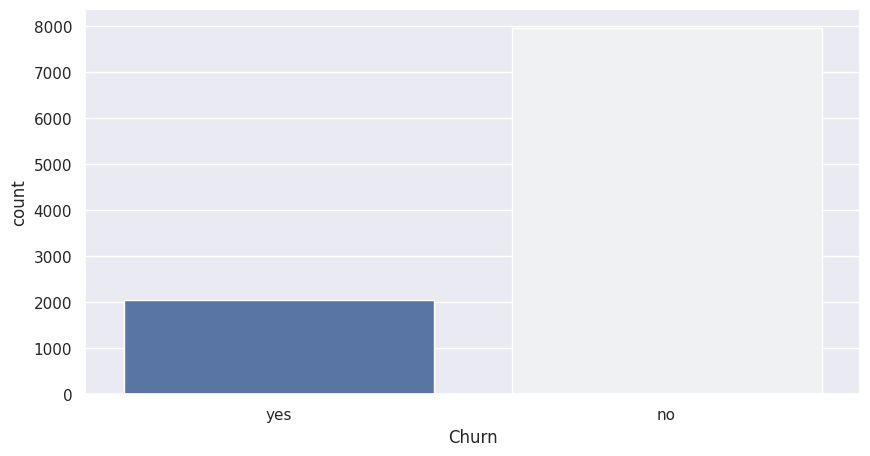

In [19]:
sns.countplot(x= response_variable, palette= "light:b_r");

In [20]:
percentage_no_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'no'].shape[0] / df4.shape[0] * 100
percentage_yes_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'yes'].shape[0] / df4.shape[0] * 100
print(f'Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}%  da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

Clientes que irão dar Churn correspondem a 20.37%  da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


- É evidente que a variável resposta possui classes desbalanceadas

### Numeric Variables

In [21]:
numeric_descriptive_statistical(numeric_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,numero_linha,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,id_cliente,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,score_credito,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,idade,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tempo_permanencia,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,saldo,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,numero_de_contas,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,salario_estimado,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


- Muitos valores distintos: score_credito, idade, saldo, salário estimado;
- Poucos valores distintos: tempo_permanencia, numero_de_contas;

#### 'score_credito'

Mínimo:350.00
Média:650.53
Mediana:652.00
Moda:850.00
Máximo:850.00



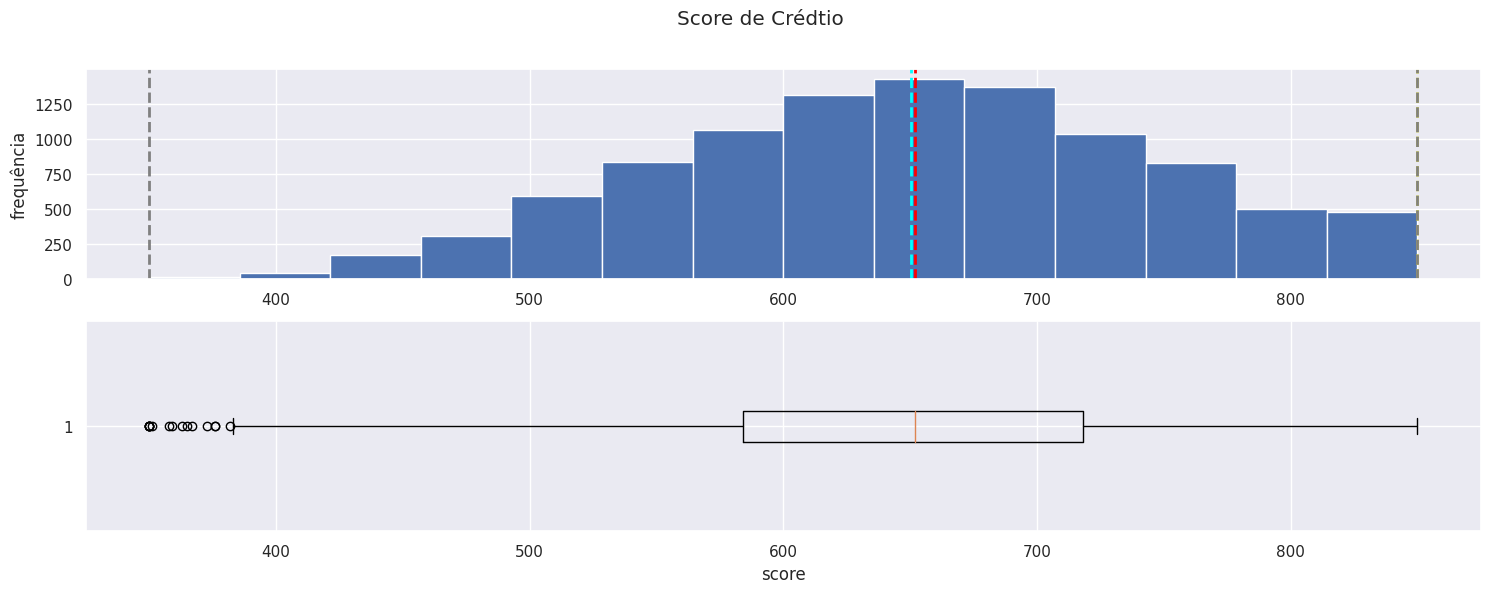

In [22]:
column = numeric_attributes['score_credito']
bins = n_bins(column)
title = "Score de Crédtio"
ylabel = "frequência"
xlabel = "score"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

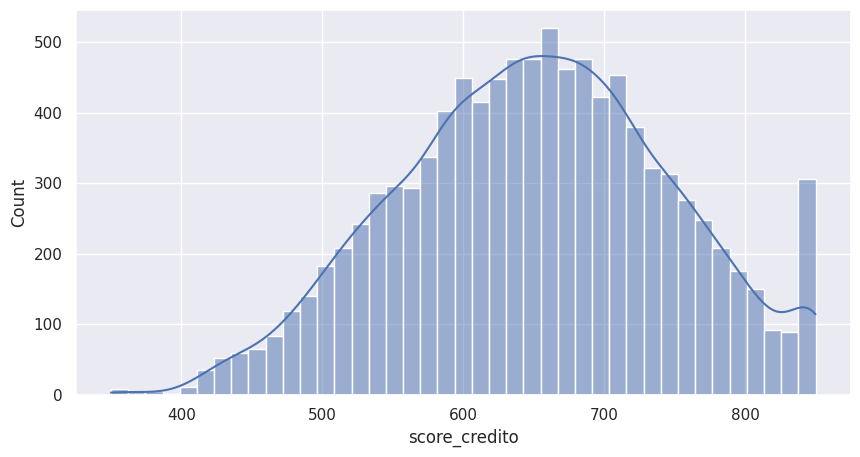

In [23]:
sns.histplot(numeric_attributes['score_credito'], kde= True);

In [24]:
# Idéia para próxima versão:

# Note: 
	# segundo os intervalos de scores de crédito da FICO:
    	# 300 - 580: muito baixo;
        # 580 - 670: baixo;
        # 670 - 740: bom;
        # 740 - 800: muito bom;
        # 800 - 850: excelente;
    # não existe uma distância considerável entre os valores da média e mediana, logo a distância interquatilica Q25 - Medina - Q75 (onde compreende a metade dos dados)
# são praticamente simétricas, fazendo com que a distribuiçaõ dos dados de 'score_credito' se aproxime de uma gaussiana (normal).
    # outliers para scores que se aproximam de 350, logo o banco não possui clientes se aproximando do mínimo score_permitido pelo banco (350)  
    # a moda é igual ao valor máximo, o que pode evidênciar que o banco possui um grupo seleto de cliente que são bons pagadores. (vale criação de caso para esse grupo)
    # hipótese: 'clientes que são bons pagadores, possuem o salário mais alto?' ou 'clentes que possuem salários altos, são bons pagadores?'

#### 'idade'

Mínimo:18.00
Média:38.92
Mediana:37.00
Moda:37.00
Máximo:92.00



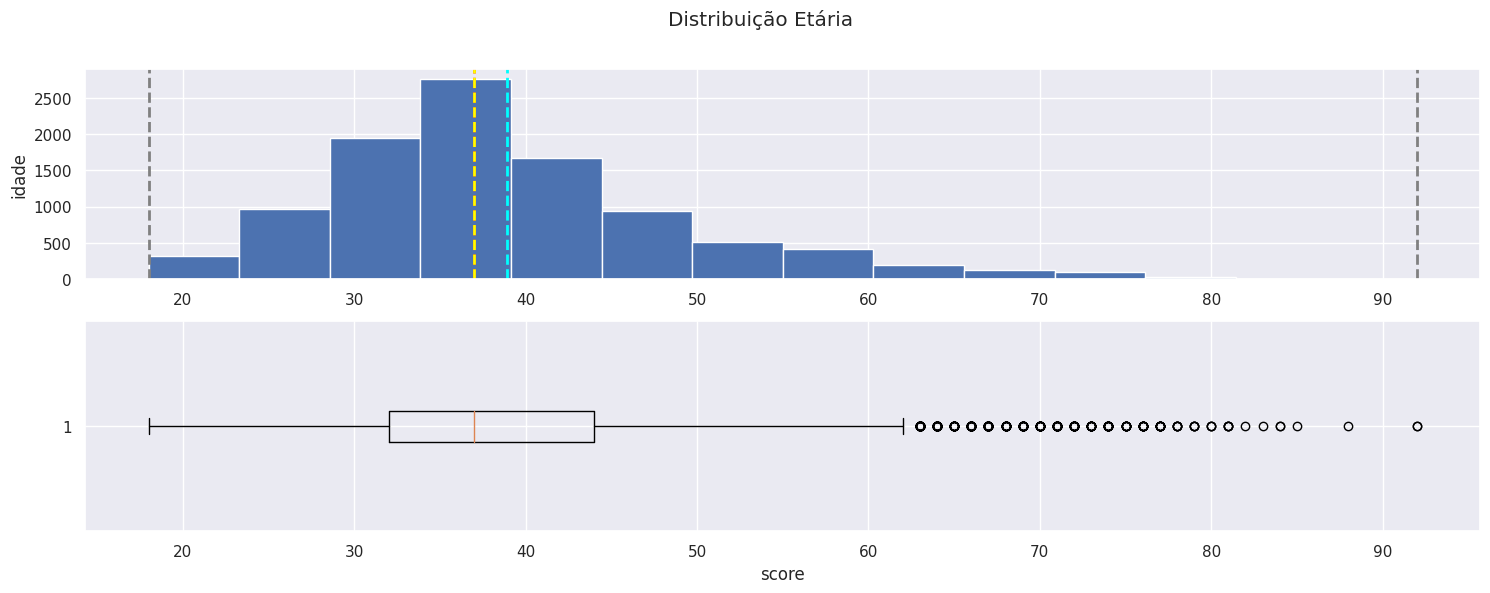

In [25]:
column = numeric_attributes['idade']
bins = n_bins(column)
title = "Distribuição Etária"
ylabel = "idade"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

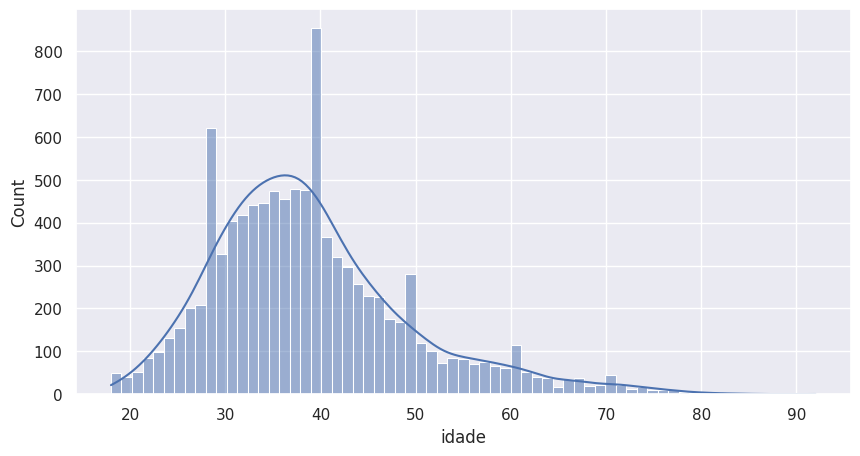

In [26]:
sns.histplot(numeric_attributes['idade'], kde= True);

#### 'saldo'

Mínimo:0.00
Média:76485.89
Mediana:97198.54
Moda:0.00
Máximo:250898.09



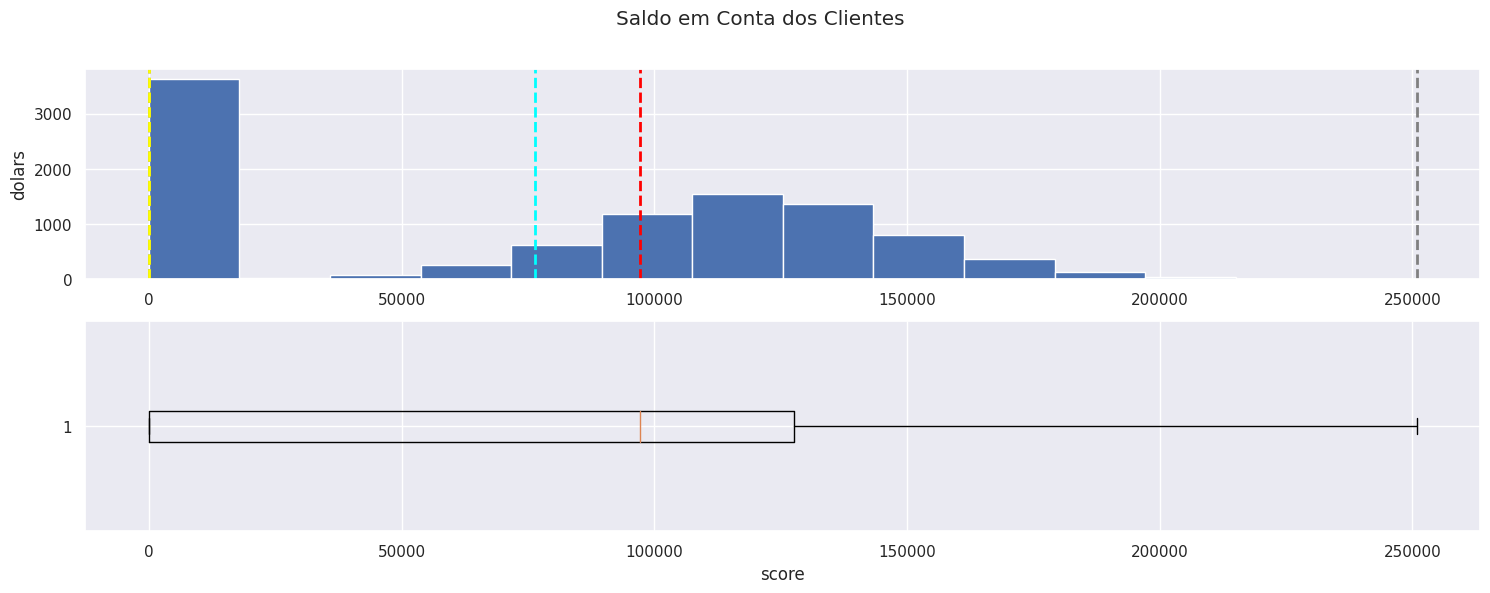

In [27]:
column = numeric_attributes['saldo']
bins = n_bins(column)
title = "Saldo em Conta dos Clientes"
ylabel = "dolars"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

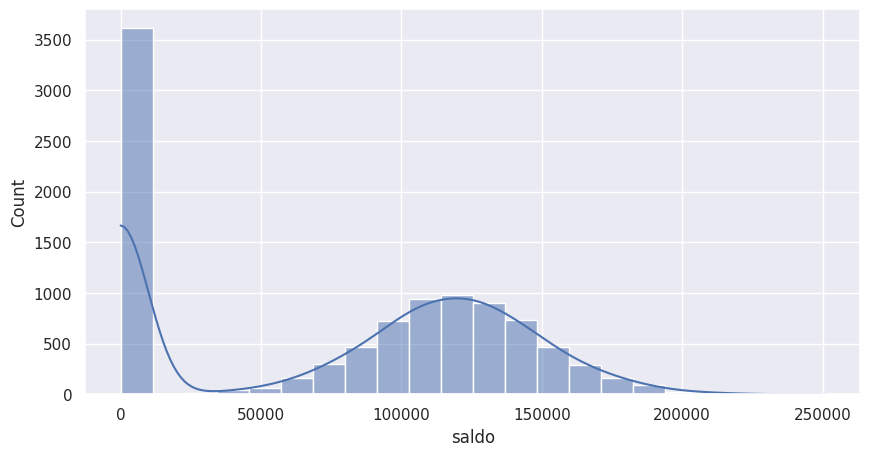

In [28]:
sns.histplot(numeric_attributes['saldo'], kde= True);

#### 'salario_estimado'

Mínimo:11.58
Média:100090.24
Mediana:100193.91
Moda:24924.92
Máximo:199992.48



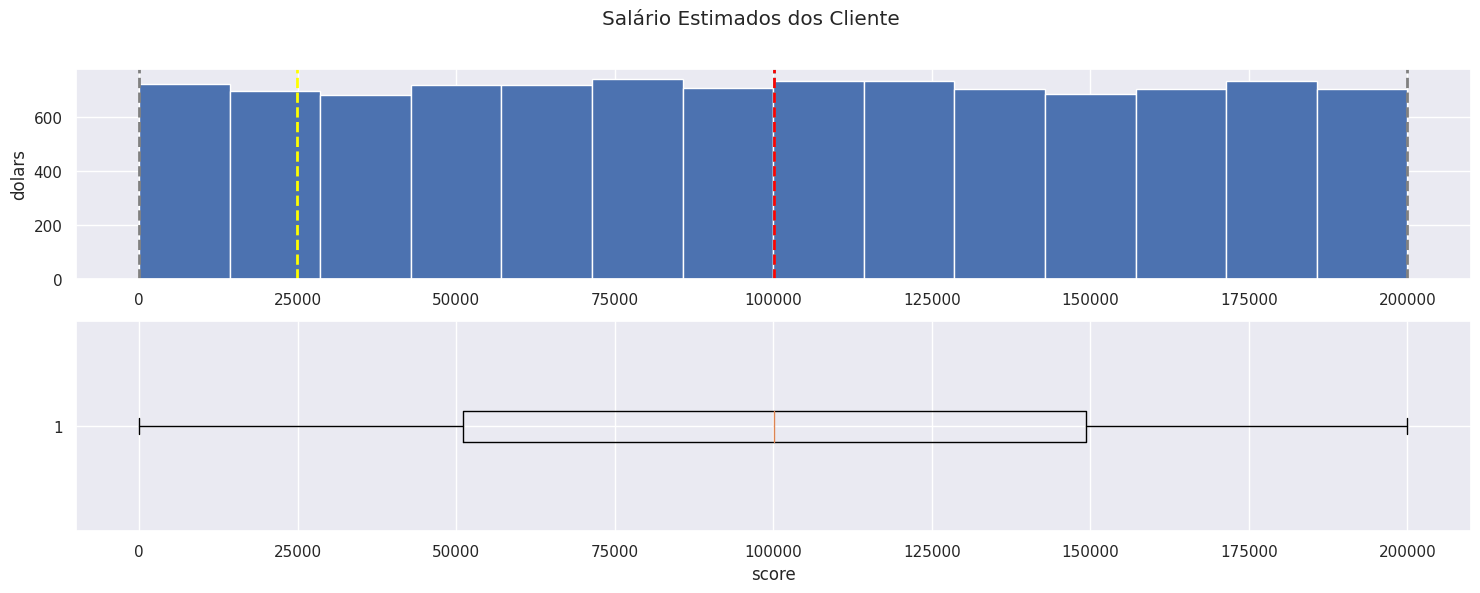

In [29]:
column = numeric_attributes['salario_estimado']
bins = n_bins(column)
title = "Salário Estimados dos Cliente"
ylabel = "dolars"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

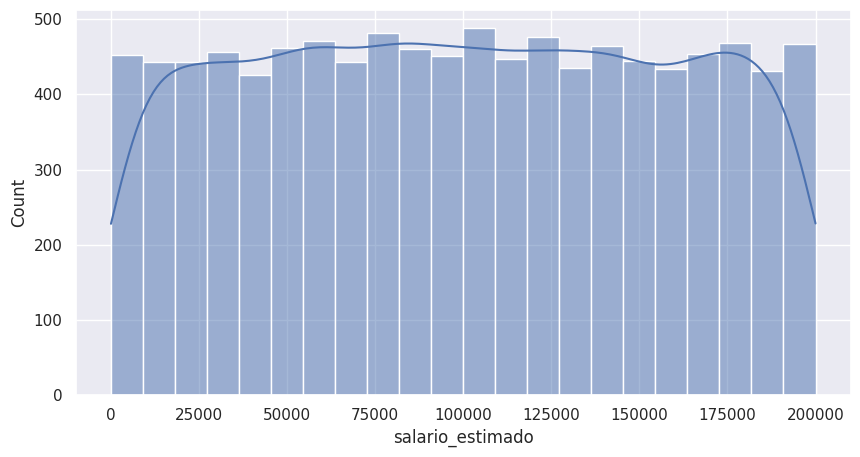

In [30]:
sns.histplot(numeric_attributes['salario_estimado'], kde= True);

#### 'tempo_permanencia'

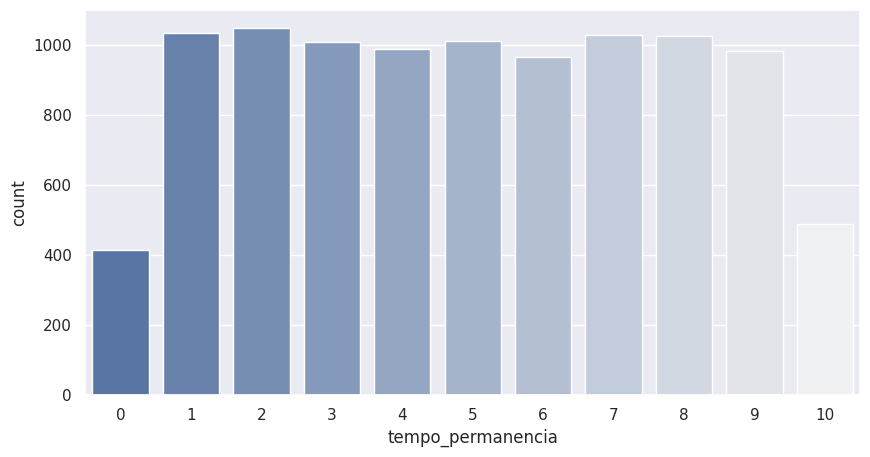

In [31]:
sns.countplot(x= df4['tempo_permanencia'], palette= "light:b_r");

In [32]:
df4[['id_cliente', 'tempo_permanencia']].groupby('tempo_permanencia').count()

,id_cliente
tempo_permanencia,
0,413
1,1035
2,1048
3,1009
4,989
5,1012
6,967
7,1028
8,1025


#### 'numero_de_contas'

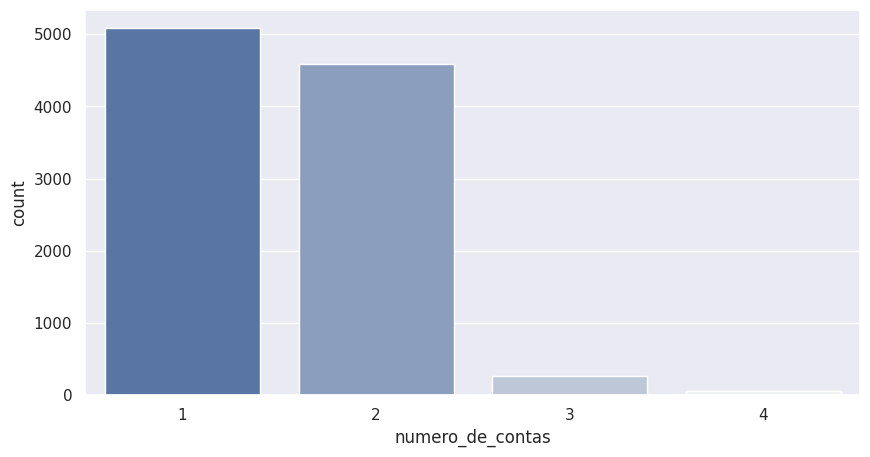

In [33]:
sns.countplot(x= df4['numero_de_contas'], palette= "light:b_r");

In [34]:
df4[['id_cliente', 'numero_de_contas']].groupby('numero_de_contas').count()

,id_cliente
numero_de_contas,
1,5084
2,4590
3,266
4,60


### Categorical Variables

In [35]:
categorical_attributes.apply(lambda x: x.unique().shape[0])

sobrenome             2932
geografia                3
genero                   2
tem_cartao_credito       2
membro_ativo             2
Churn                    2
dtype: int64

#### 'geografia'

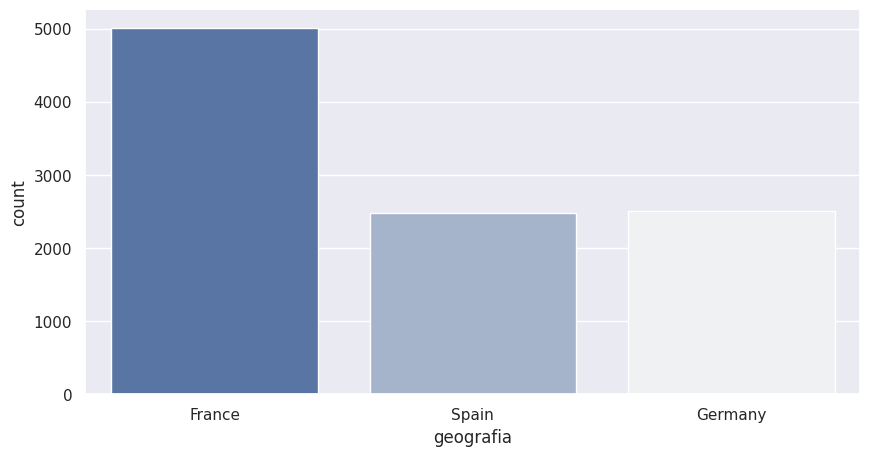

In [36]:
sns.countplot(x= df4['geografia'], palette= "light:b_r");

In [37]:
df4[['id_cliente', 'geografia']].groupby('geografia').count()

,id_cliente
geografia,
France,5014
Germany,2509
Spain,2477


#### 'genero'

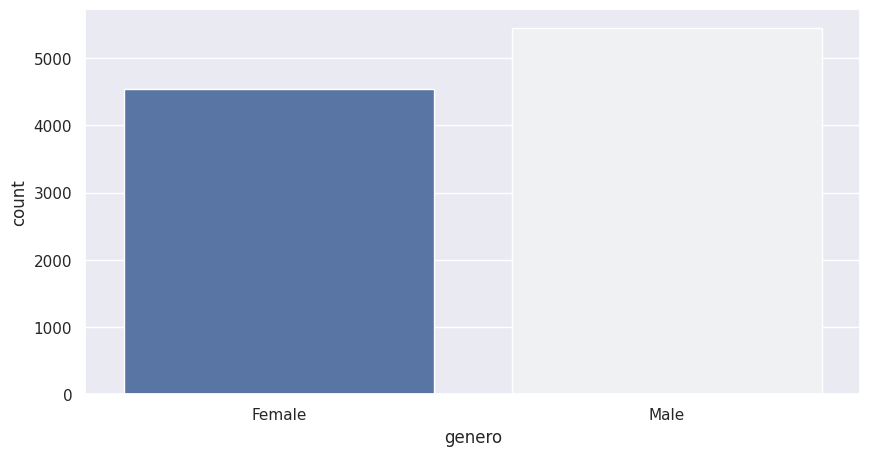

In [38]:
sns.countplot(x= df4['genero'], palette= "light:b_r");

In [39]:
df4[['id_cliente', 'genero']].groupby('genero').count()

,id_cliente
genero,
Female,4543
Male,5457


#### 'tem_cartao_credito'

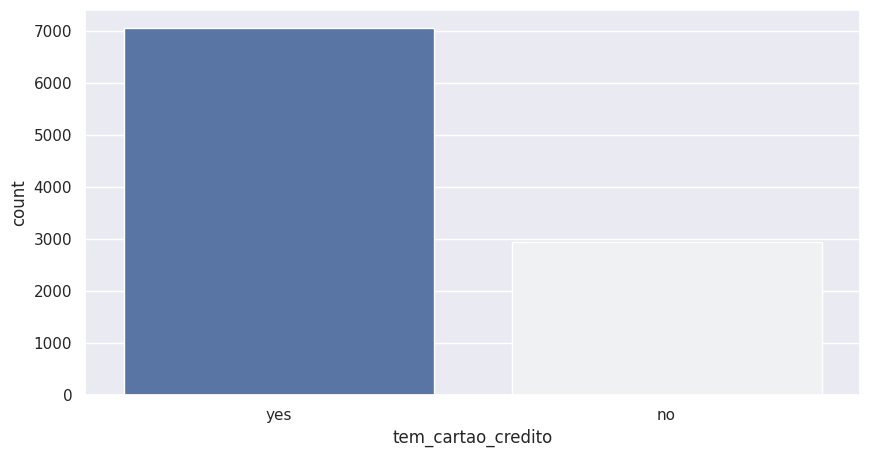

In [40]:
sns.countplot(x= df4['tem_cartao_credito'], palette= "light:b_r");

In [41]:
df4[['id_cliente', 'tem_cartao_credito']].groupby('tem_cartao_credito').count()

,id_cliente
tem_cartao_credito,
no,2945
yes,7055


#### 'membro_ativo'

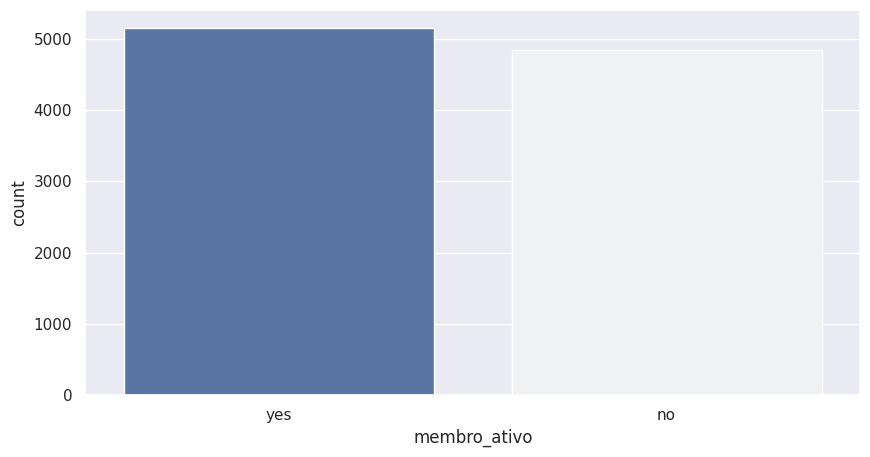

In [42]:
sns.countplot(x= df4['membro_ativo'], palette= "light:b_r");

In [43]:
df4[['id_cliente', 'membro_ativo']].groupby('membro_ativo').count()

,id_cliente
membro_ativo,
no,4849
yes,5151


## Bivariate and Multivariate Analysis

## Note:
Próxima versão: 
- Adicionar 1º e 3º quartil na função numerical_estatistic_statistical;
- Interpretação Estatística e de Negócio na Análise Univariada;
- Análise Bivariada com insights das hipóteses criadas e Análise Multivariada;

# Feature Engineering II (Data Preparation)

In [44]:
df5 = df4.copy()

In [45]:
data_for_filtering = df4.copy()

## Data Filtering

In [46]:
columns_to_delete = ['numero_linha','id_cliente','sobrenome']
filtered_data = data_for_filtering.drop(columns_to_delete, axis= 1)

In [47]:
filtered_data.head()

,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn
0,619,France,Female,42,2,0.00,1,yes,yes,101348.88,yes
1,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,no
2,502,France,Female,42,8,159660.80,3,yes,no,113931.57,yes
3,699,France,Female,39,1,0.00,2,no,no,93826.63,no
4,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,no


## Splitting Dataframe into Training and Test Dataset

In [48]:
X = filtered_data.drop(columns = ['Churn'])
y = filtered_data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 42)

## Scaling I (Encoding) *Train Data & Test Data

In [49]:
label_encoder = LabelEncoder() # troca de categorias por números de 1 a n. (geografia, gênero)
# e transformação comum para variáveis tem_cartao_credito, membro_ativo e Churn, Yes = 1 e No = 0.

### 'geografia'

In [50]:
geografia_dict = {'France': 0, 'Germany': 1, 'Spain': 2}
X_train['geografia'] = X_train['geografia'].apply(lambda x: geografia_dict[x])
X_test['geografia'] = X_test['geografia'].apply(lambda x: geografia_dict[x])

### 'gênero'

In [51]:
genero_dict = {'Female': 0, 'Male': 1}
X_train['genero'] = X_train['genero'].apply(lambda x: genero_dict[x])
X_test['genero'] = X_test['genero'].apply(lambda x: genero_dict[x])

### 'tem_cartao_credito'

In [52]:
X_train['tem_cartao_credito'] = X_train['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['tem_cartao_credito'] = X_test['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)

### 'membro_ativo'

In [53]:
X_train['membro_ativo'] = X_train['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['membro_ativo'] = X_test['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)

### Response Variable (Churn)

In [54]:
y_train = y_train.apply(lambda x: 1 if x == 'yes' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'yes' else 0)

## Scaling II (Normalization) *Train data & Test Data

### Standardization (or  X-score Normalization)

- Na Análise Univariada é possível verificar que não temos nenhuma distribuição normal nas variáveis numéricas, logo será descartado o processo de normalização.

### Normalization (or Rescaling)

In [55]:
robust_scaler = RobustScaler() # rescala para variáveis numéricas com distribuições não gaussianas que possuem outliers (score_credito, idade, numero_de_contas)
min_max_scaler = MinMaxScaler() # rescala para variáveis numéricas com distribuições não gaussianas que não possuem outliers (saldo, salario_estimado, tempo_permanencia)

#### 'score_credito'

In [56]:
X_train['score_credito'] = robust_scaler.fit_transform(X_train[['score_credito']].values)
X_test['score_credito'] = robust_scaler.transform(X_test[['score_credito']].values)

#outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/score_credito_scaler.pkl', 'wb')
#pickle.dump(robust_scaler, outfile)
#outfile.close()

#### 'idade'

In [57]:
X_train['idade'] = robust_scaler.fit_transform(X_train[['idade']].values)
X_test['idade'] = robust_scaler.transform(X_test[['idade']].values)

#outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/idade_scaler.pkl', 'wb')
#pickle.dump(robust_scaler, outfile)
#outfile.close()

#### 'saldo'

In [58]:
X_train['saldo'] = min_max_scaler.fit_transform(X_train[['saldo']].values)
X_test['saldo'] = min_max_scaler.transform(X_test[['saldo']].values)

#outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/saldo_scaler.pkl', 'wb')
#pickle.dump(min_max_scaler, outfile)
#outfile.close()

#### 'salario_estimado'

In [59]:
X_train['salario_estimado'] = min_max_scaler.fit_transform(X_train[['salario_estimado']].values)
X_test['salario_estimado'] = min_max_scaler.transform(X_test[['salario_estimado']].values)
#outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/salario_estimado_scaler.pkl', 'wb')
#pickle.dump(min_max_scaler, outfile)
#outfile.close()

#### 'tempo_permanencia'

In [60]:
X_train['tempo_permanencia'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia']].values)
X_test['tempo_permanencia'] = min_max_scaler.transform(X_test[['tempo_permanencia']].values)

#outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/tempo_permanencia_scaler.pkl', 'wb')
#pickle.dump(min_max_scaler, outfile)
#outfile.close()

## Balancing Response Variable *only Train Data

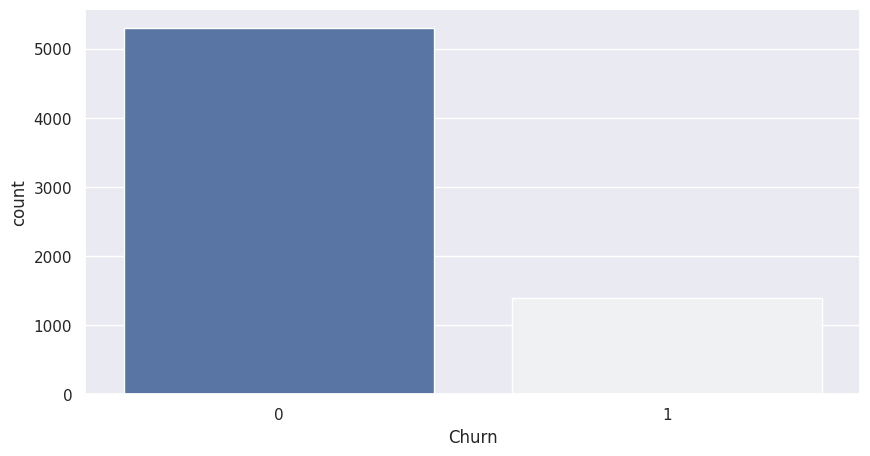

In [61]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train, palette= "light:b_r");

- Como a variável resposta está desbalanceada, aplico uma técnica (algoritmo) que irá balancear os dados e evitar enviesamento do modelo.

In [62]:
# Over-Sampling na variável resposta dos dados de treino 
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

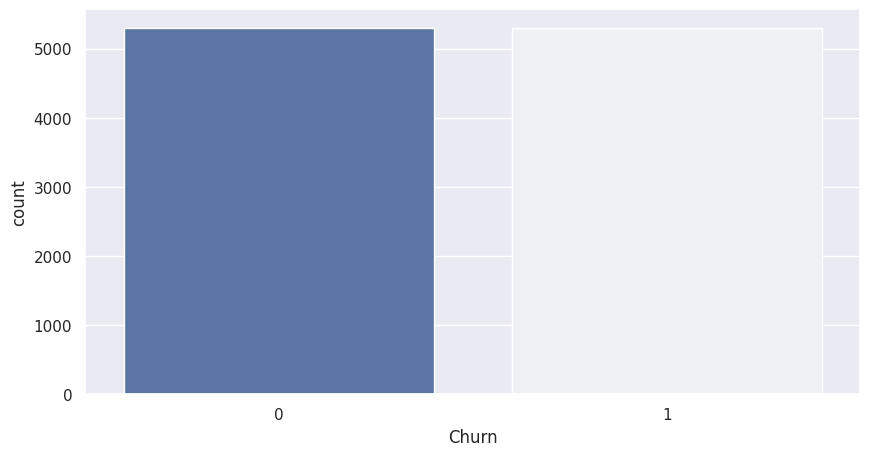

In [63]:
# Visualizando proporção da variável resposta
sns.countplot(x= y_train, palette= "light:b_r");

## Note:

- Ao escalar os dados usa-se métricas que são definidas por todo o conjunto de dados, então decidi dividir os dados de treino e teste antes de escalar, pois assim, eu teria dois conjuntos de dados, com métricas únicas para cada conjunto, anulando o enviesamento do modelo. 
		Ex.: A normalização MinMaxScaler utiliza o valor mínimo e máximo do conjunto de dados. Se a normalização tivesse sido feita antes da divisão dos dados em conjuntos de treino e teste, a normalização dos dois conjuntos teriam o mesmo padrão escalar, de um único conjunto, pois iriam dividir os elementos mínimos e máximo, logo estaria injetando informações futuras no conjunto de dados de treinamneto, e assim, enviesando o modelo. Com normalização realizada depois da divisão dos dados em treino e teste, os valores mínimo e máximo seriam únicos para cada conjunto, assim, isolando os dados de treino com os dados de teste, evitando o enviesamento do modelo.

# Feature Selection

In [64]:
df6 = df5.copy()

## Boruta Feature Selector

In [65]:
X_train_boruta= X_train.values
y_train_boruta = y_train.values

In [66]:
# Intanciando RandomForestRegressor
random_forest = RandomForestRegressor(n_jobs=-1)

# Intanciando Boruta
boruta = BorutaPy(random_forest, n_estimators='auto', verbose= 2, random_state= 42).fit(X_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	4


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	4


### Best Features from Boruta 

In [67]:
columns_selected = boruta.support_.tolist()

columns_selected_boruta = X_train.iloc[:, columns_selected].columns.to_list()

columns_not_selected_boruta = list(np.setdiff1d(X_train.columns, columns_selected_boruta))

In [68]:
columns_selected_boruta

['score_credito',
 'idade',
 'tempo_permanencia',
 'saldo',
 'numero_de_contas',
 'salario_estimado']

In [69]:
columns_not_selected_boruta

['genero', 'geografia', 'membro_ativo', 'tem_cartao_credito']

# Machine Learning and Model Metrics 

In [70]:
df7 = df6.copy()

## Splitting Dataframe into Training and Test Dataset and Selecting Best Features to Model

In [71]:
#columns_selected_boruta = ['score_credito',
# 'idade',
# 'saldo',
# 'numero_de_contas',
# 'membro_ativo',
# 'salario_estimado']

X_train_model = X_train[columns_selected_boruta]
y_train_model = y_train

X_test_model = X_test[columns_selected_boruta]
y_test_model = y_test

## Cross Validation - Random Forest

In [72]:
kfold = KFold(5, shuffle= True, random_state= 42)

random_forest_cv = RandomForestClassifier(n_estimators= 150, n_jobs= -1, random_state= 42)

accuracy_rf = cross_val_score(random_forest_cv, X_train_model, y_train_model, cv= kfold)

print(f'Acurácia (Cross Validation): {round(accuracy_rf.mean(), 2)} +/-{round(accuracy_rf.std(), 2)}')

Acurácia (Cross Validation): 0.86 +/-0.01


## Training and Testing -  Random Forest

In [73]:
# Instanciando o Modelo
model = RandomForestClassifier(n_estimators= 150, n_jobs=-1, random_state= 42)

# Treinando o modelo
model.fit(X_train_model, y_train_model)

#outfile = open('/home/rnglinux/projetos/Churn-Predict/model/model_v1.pkl', 'wb')
#pickle.dump(model, outfile)
#outfile.close()

RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42)

### Predict

In [74]:
# Previsão com dados de teste
yhat_model = model.predict(X_test_model)

## Metrics

### Confusion Matrix

In [83]:
matrix_absolute = confusion_matrix(y_test_model, yhat_model)
matrix_percentage = confusion_matrix(y_test_model, yhat_model, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

- Matriz Absoluta
[[2356  301]
 [ 288  355]]


In [86]:
print('- Matriz Percentual')
print(matrix_percentage)

- Matriz Percentual
[[0.88671434 0.11328566]
 [0.44790047 0.55209953]]


In [84]:
true_negative_abs = matrix_absolute[0][0]
false_positive_abs = matrix_absolute[0][1]
false_negative_abs = matrix_absolute[1][0]
true_positive_abs = matrix_absolute[1][1]

print(f'True Negative: {true_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'True Positive: {true_positive_abs}')

True Negative: 2356
False Positive: 301
False Negative: 288
True Positive: 355


In [87]:
true_negative_perc = matrix_percentage[0][0]
false_positive_perc = matrix_percentage[0][1]
false_negative_perc = matrix_percentage[1][0]
true_positive_perc = matrix_percentage[1][1]

print(f'True Negative: {true_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'True Positive: {true_positive_perc * 100 :.2f}%')

True Negative: 88.67%
False Positive: 11.33%
False Negative: 44.79%
True Positive: 55.21%


In [79]:
# Métricas de Performance do Modelo
print(classification_report(y_test_model, yhat_model))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2657
           1       0.54      0.55      0.55       643

    accuracy                           0.82      3300
   macro avg       0.72      0.72      0.72      3300
weighted avg       0.82      0.82      0.82      3300



## Note:
O modelo consegue prever cerca de 55.21% dos clientes que de fato irão dar churn, porém 44.79% dos que não querem sair da empresa, o modelo prevê que irão sair. 
Logo, é possível observar um sobreajuste significativo do modelo para previsão de Churn.

Para a próxima versão:
1. Multi-modelagem para definir o melhor modelo.
2. Estudar os melhores parâmetros para serem aplicados no modelo escolhido.
3. Tratar o sobreajuste do modelo.

# Business Translation

In [80]:
df8 = df7.copy()

## What is Top Bank's current Churn rate?

- Foi respondida na análise univariada da variável resposta. 20.37% de Churn Rate.

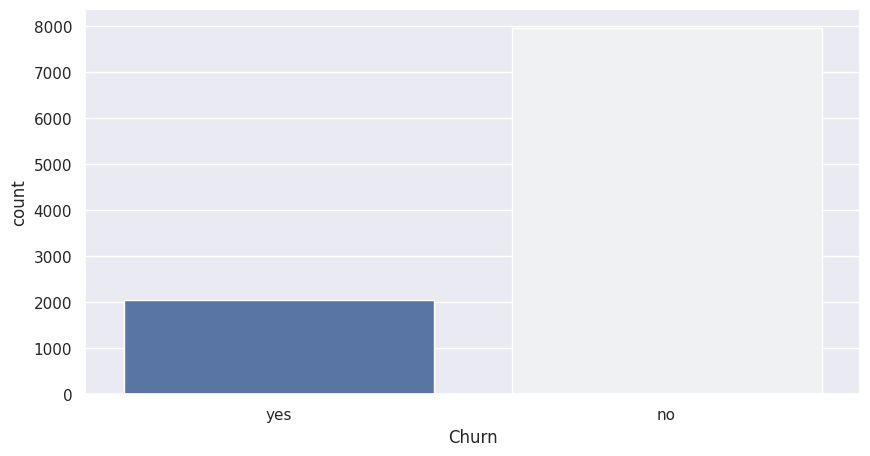

In [81]:
sns.countplot(x=df4['Churn'], palette= "light:b_r");

In [82]:
percentage_no_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'no'].shape[0] / df4.shape[0] * 100
percentage_yes_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'yes'].shape[0] / df4.shape[0] * 100
print(f'R: Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}% da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

R: Clientes que irão dar Churn correspondem a 20.37% da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


## How does the churn rate vary monthly?

- Será respondido no segundo ciclo.

## What is the performance of the model in classifying customers as churns?

    R: O modelo possui uma precisão de 82% para indentificar churns neste primeiro ciclo.

## What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

- Será respondido no segundo ciclo.

# Deploy

## Note:
Próxima versão: criação da classe para deploy.

# Referências

- Alura - Lidando com desbalanceamente de dados (https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados#:~:text=%C3%89%20uma%20t%C3%A9cnica%20que%20consiste%20em%20aumentar%20a%20quantidade%20de,da%20classe%20com%20menor%20frequ%C3%AAncia)
- Imbalanced Learn - Over-sampling (https://imbalanced-learn.org/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn)